<h2 style="color:skyblue">Required Libraries</h2>

In [1]:
# Data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.spatial.distance import cosine

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, InputLayer, Flatten, Dense, LSTM, GRU, Bidirectional, Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant


<h3 style="color:#79ff00">Loading Dataset</h3>

In [2]:
train_df = pd.read_csv("train_data.csv")
val_df = pd.read_csv("val_data.csv")
test_df = pd.read_csv("test_data.csv")

val_df.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,236,236,128.0,96.0,36.2800,149.0,113.0,92.0,28.5,33.029605,...,378.146104,726.000000,27.92,1,0.0,1.0,-0.03,237,0,9
1,237,237,129.0,94.0,37.0425,136.0,102.0,83.0,28.0,33.029605,...,376.746753,729.666667,27.92,1,0.0,1.0,-0.03,238,0,9
2,238,238,133.0,94.0,37.8050,141.0,106.0,86.0,33.0,33.029605,...,375.347403,733.333333,27.92,1,0.0,1.0,-0.03,239,0,9
3,239,239,137.0,94.0,38.5675,142.0,106.0,87.0,30.0,33.029605,...,373.948052,737.000000,27.92,1,0.0,1.0,-0.03,240,0,9
4,240,240,138.0,96.0,39.3300,142.0,108.0,87.0,30.5,33.029605,...,372.548701,740.666667,27.92,1,0.0,1.0,-0.03,241,0,9


<h3 style="color:#79ff00">Correlation Heatmap</h3>

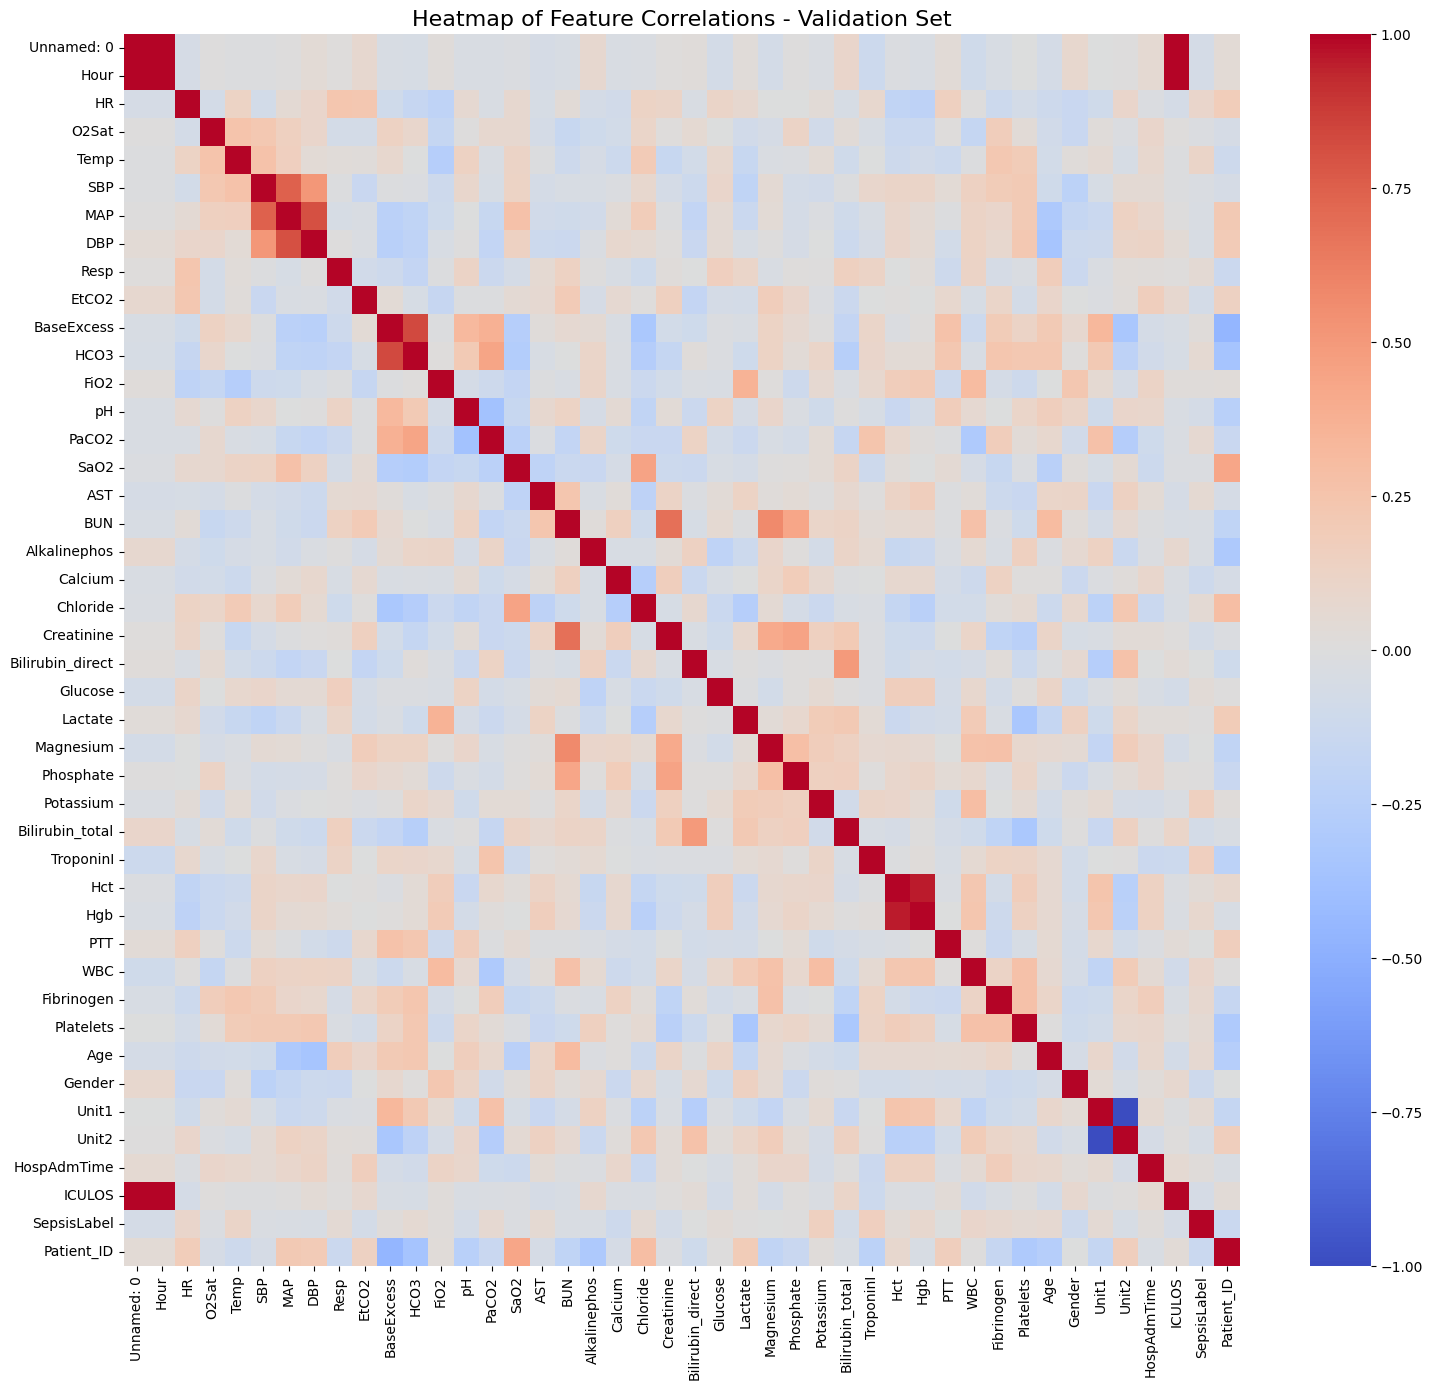

In [3]:
val_numeric = val_df.select_dtypes(include='number')

corr_matrix = val_numeric.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, cbar=True)
plt.title("Heatmap of Feature Correlations - Validation Set", fontsize=16)
plt.show()

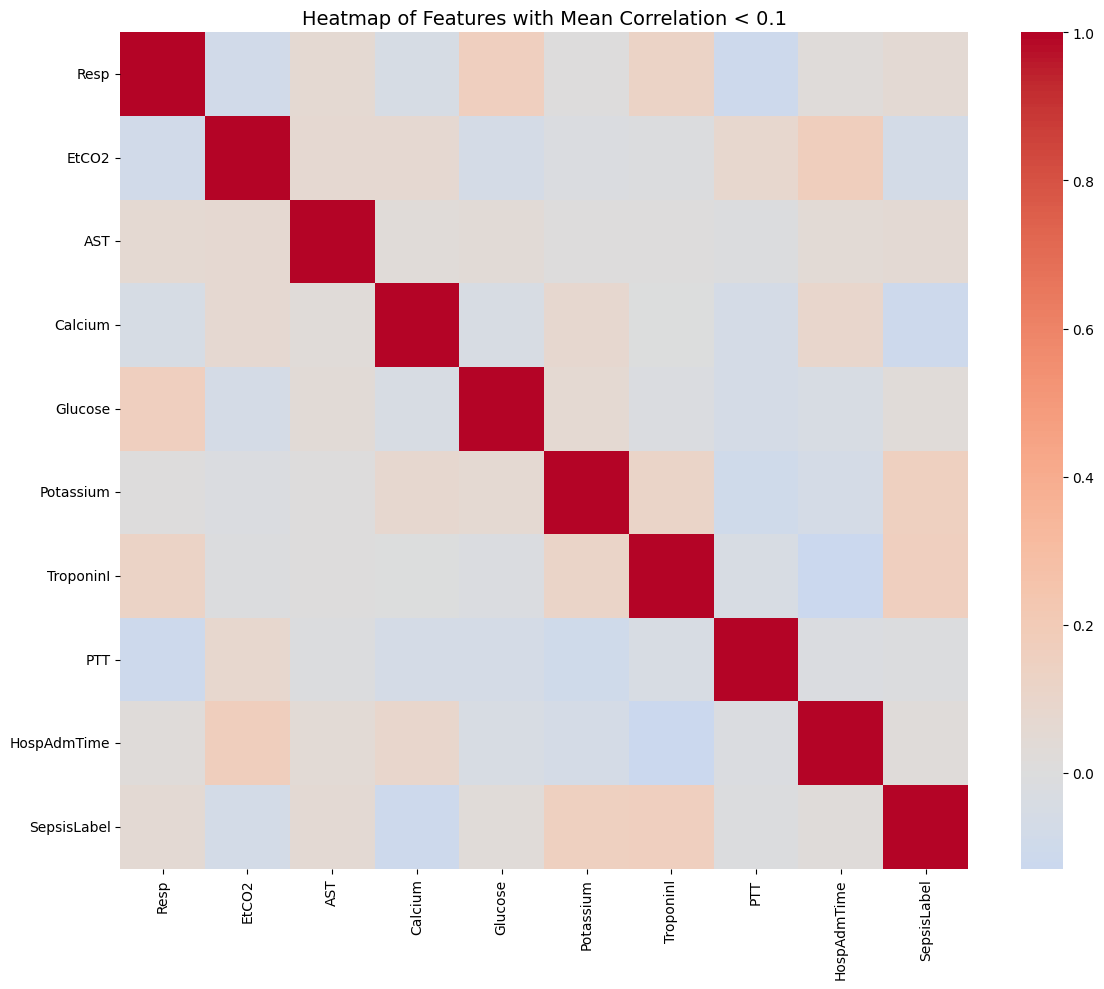

In [4]:
mean_corr = corr_matrix.abs().mean()

low_corr_cols = mean_corr[mean_corr < 0.1].index.tolist()

low_corr_matrix = corr_matrix.loc[low_corr_cols, low_corr_cols]

plt.figure(figsize=(12, 10))
sns.heatmap(low_corr_matrix, cmap='coolwarm', center=0, cbar=True)
plt.title("Heatmap of Features with Mean Correlation < 0.1", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
lowest_20_cols = mean_corr.sort_values().head(20).index.tolist()

print("20 features with lowest correlation:")
print(lowest_20_cols)

20 features with lowest correlation:
['SepsisLabel', 'Glucose', 'PTT', 'Resp', 'TroponinI', 'Potassium', 'Calcium', 'HospAdmTime', 'EtCO2', 'AST', 'Alkalinephos', 'Gender', 'O2Sat', 'Phosphate', 'Bilirubin_direct', 'Unnamed: 0', 'Hour', 'ICULOS', 'Temp', 'HR']


In [6]:
lowest_20_cols.remove('Hour')
grouped_data = val_df[['Patient_ID', 'Hour'] + lowest_20_cols]

patient_groups = grouped_data.groupby('Patient_ID')

first_patient_id = list(patient_groups.groups.keys())[0]
first_patient_data = patient_groups.get_group(first_patient_id).sort_values(by='Hour')

print(f"Patient's time series {first_patient_id}:")
print(first_patient_data.head())


Patient's time series 9:
   Patient_ID  Hour  SepsisLabel     Glucose        PTT  Resp  TroponinI  \
0           9   236            0  135.500000  25.122093  28.5   6.990198   
1           9   237            0  136.333333  25.202326  28.0   6.992099   
2           9   238            0  137.166667  25.282558  33.0   6.993999   
3           9   239            0  138.000000  25.362791  30.0   6.995900   
4           9   240            0  138.833333  25.443023  30.5   6.997801   

   Potassium   Calcium  HospAdmTime  ...        AST  Alkalinephos  Gender  \
0   3.750000  7.550000        -0.03  ...  30.873418     51.556110       1   
1   3.722222  7.555556        -0.03  ...  30.933544     51.526185       1   
2   3.694444  7.561111        -0.03  ...  30.993671     51.496259       1   
3   3.666667  7.566667        -0.03  ...  31.053797     51.466334       1   
4   3.638889  7.572222        -0.03  ...  31.113924     51.436409       1   

   O2Sat  Phosphate  Bilirubin_direct  Unnamed: 0  ICUL

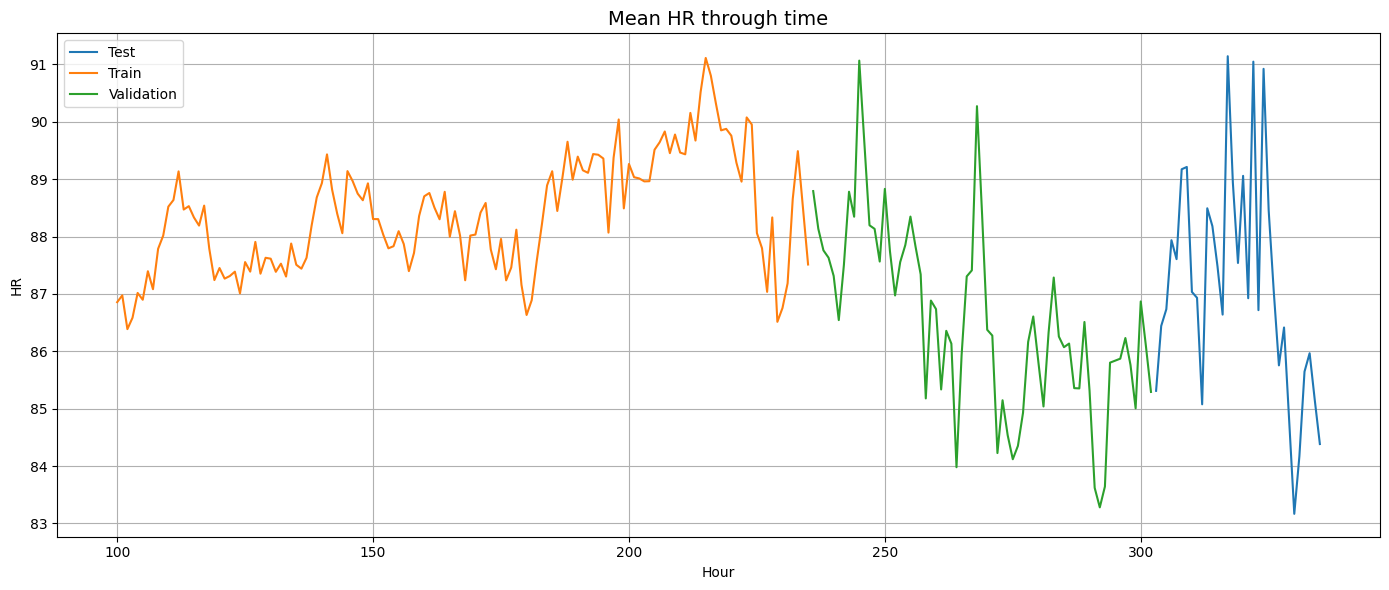

In [7]:
train_df['split'] = 'Train'
val_df['split'] = 'Validation'
test_df['split'] = 'Test'

combined = pd.concat([train_df, val_df, test_df])

plt.figure(figsize=(14, 6))
for name, group in combined.groupby('split'):
    hr_by_hour = group.groupby('Hour')['HR'].mean()
    plt.plot(hr_by_hour.index, hr_by_hour.values, label=name)

plt.title('Mean HR through time', fontsize=14)
plt.xlabel('Hour')
plt.ylabel('HR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


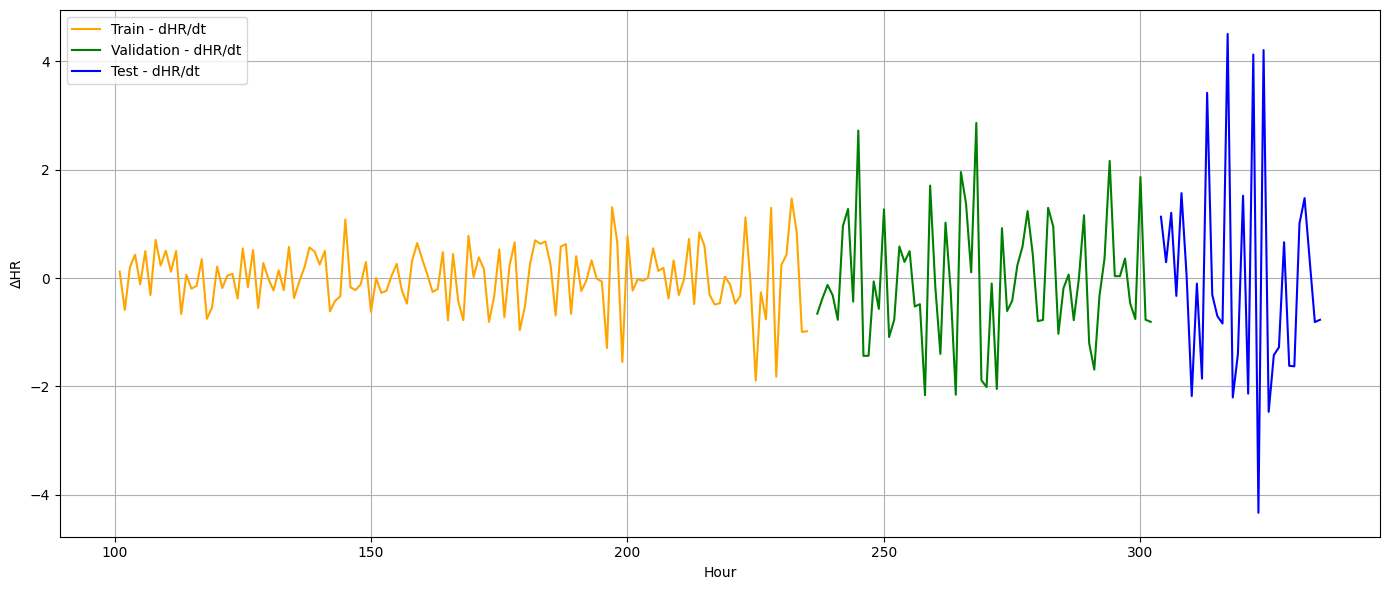

In [8]:
train_hr = train_df.groupby('Hour')['HR'].mean()
val_hr = val_df.groupby('Hour')['HR'].mean()
test_hr = test_df.groupby('Hour')['HR'].mean()

train_hr_diff = train_hr.diff()
val_hr_diff = val_hr.diff()
test_hr_diff = test_hr.diff()

plt.figure(figsize=(14, 6))
plt.plot(train_hr_diff.index, train_hr_diff.values, label='Train - dHR/dt', color='orange')
plt.plot(val_hr_diff.index, val_hr_diff.values, label='Validation - dHR/dt', color='green')
plt.plot(test_hr_diff.index, test_hr_diff.values, label='Test - dHR/dt', color='blue')

plt.xlabel('Hour')
plt.ylabel('ΔHR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<h4 style="color:#79ff00">Checking the stability</h4>

In [9]:
train_df['split'] = 'Train'
val_df['split'] = 'Validation'
test_df['split'] = 'Test'

all_df = pd.concat([train_df, val_df, test_df])

all_hr = all_df.groupby('Hour')['HR'].mean().dropna()
all_hr_diff = all_hr.diff().dropna()

adf_result_diff = adfuller(all_hr_diff)

print("ADF Statistic:", adf_result_diff[0])
print("p-value:", adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_diff[1] < 0.05:
    print("✅ Stable (p < 0.05)")
else:
    print("❌ Not Stable (p ≥ 0.05)")


ADF Statistic: -7.078623548690887
p-value: 4.729808768983969e-10
Critical Value (1%): -3.4598
Critical Value (5%): -2.8745
Critical Value (10%): -2.5737
✅ Stable (p < 0.05)


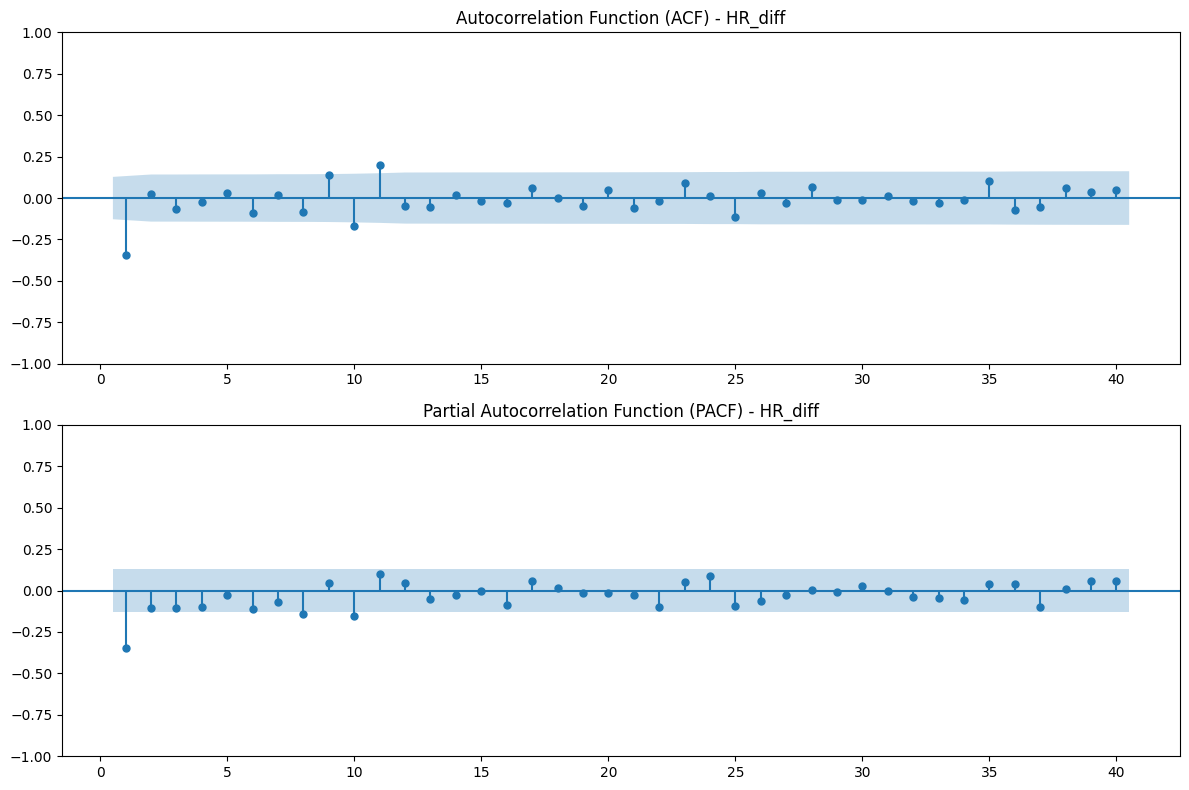

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(all_hr_diff, ax=ax[0], lags=40, zero=False)
ax[0].set_title('Autocorrelation Function (ACF) - HR_diff')

plot_pacf(all_hr_diff, ax=ax[1], lags=40, zero=False, method='ywm')  # method
ax[1].set_title('Partial Autocorrelation Function (PACF) - HR_diff')

plt.tight_layout()
plt.show()


<h3 style="color:#79ff00">SARIMAX</h3>

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


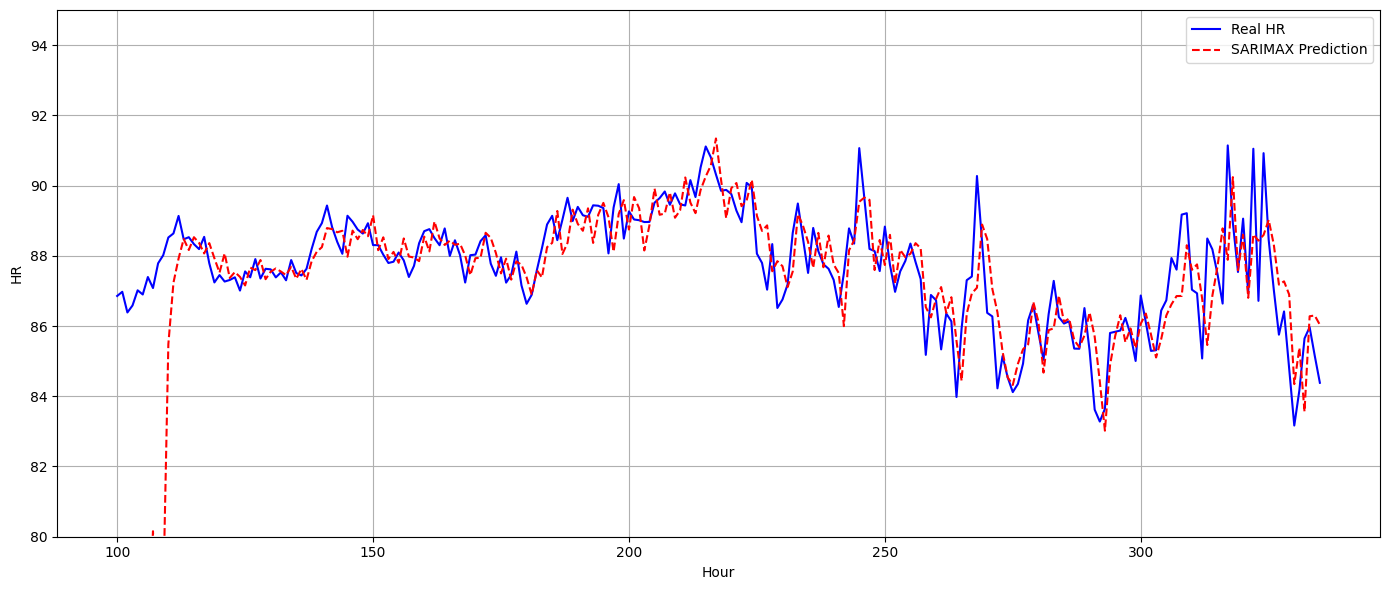

In [11]:
series = all_df[['Hour', 'HR', 'O2Sat']].groupby('Hour').mean().sort_index()
series = series.dropna()

y = series['HR']
X = series[['O2Sat']]

model = SARIMAX(
    y,
    exog=X,
    order=(10, 1, 10),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)

forecast = results.predict(start=0, end=len(y)-1, exog=X)

plt.figure(figsize=(14, 6))
plt.plot(y.index, y, label='Real HR', color='blue')
plt.plot(forecast.index, forecast, label='SARIMAX Prediction', color='red', linestyle='--')
plt.ylim(80, 95)
plt.xlabel('Hour')
plt.ylabel('HR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
valid_range = y.index >= 120
r2_cleaned = r2_score(y[valid_range], forecast[valid_range])
print(f"R²: {r2_cleaned:.4f}")


R²: 0.6834


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


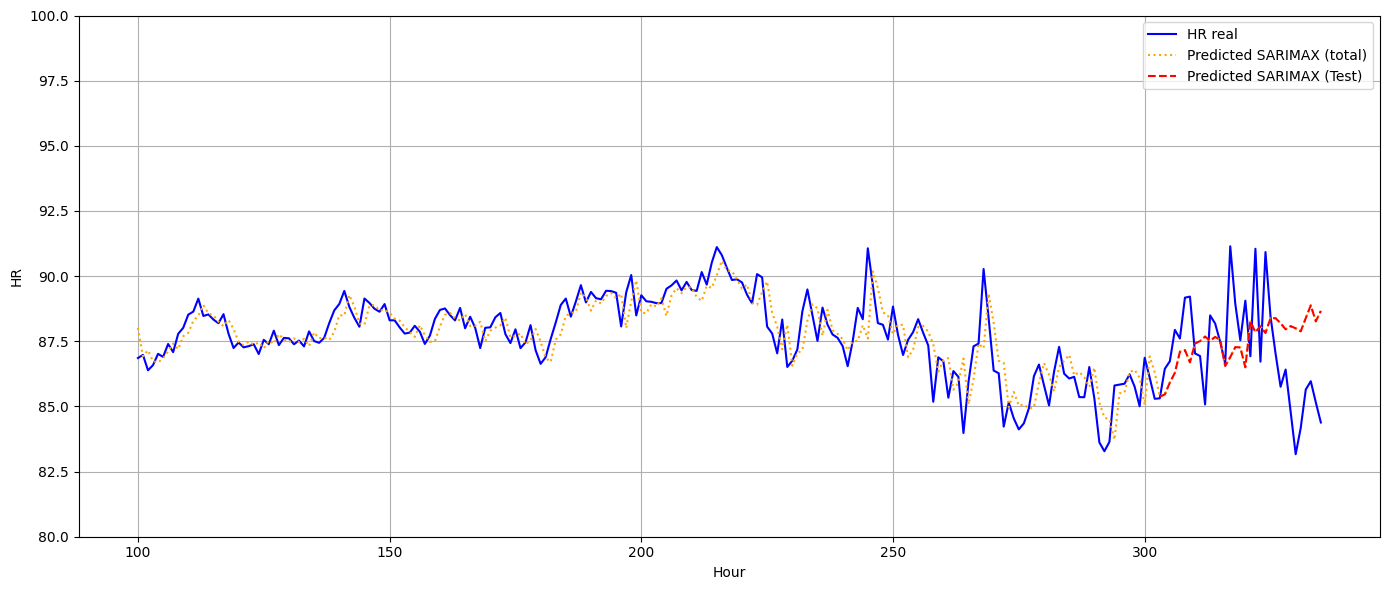

In [13]:
train_df['split'] = 'Train'
val_df['split'] = 'Validation'
test_df['split'] = 'Test'

all_df = pd.concat([train_df, val_df, test_df])
all_df = all_df.sort_values(by='Hour')

series = all_df[['Hour', 'HR', 'O2Sat', 'split']].groupby(['Hour', 'split']).mean().reset_index()

train_val = series[series['split'].isin(['Train', 'Validation'])]
test = series[series['split'] == 'Test']

y_train_val = train_val['HR'].values
X_train_val = train_val[['O2Sat']].values
X_test = test[['O2Sat']].values

model = SARIMAX(
    y_train_val,
    exog=X_train_val,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

forecast_in_sample = results.fittedvalues

forecast_test = results.predict(
    start=len(y_train_val),
    end=len(y_train_val) + len(X_test) - 1,
    exog=X_test
)

forecast_full = pd.concat([
    pd.Series(forecast_in_sample, index=train_val['Hour'].values),
    pd.Series(forecast_test, index=test['Hour'].values)
])

plt.figure(figsize=(14, 6))
plt.plot(series['Hour'], series['HR'], label='HR real', color='blue')
plt.plot(forecast_full.index, forecast_full.values, label='Predicted SARIMAX (total)', color='orange', linestyle=':')
plt.plot(test['Hour'].values, forecast_test, label='Predicted SARIMAX (Test)', color='red', linestyle='--')

plt.xlabel('Hour')
plt.ylabel('HR')
plt.ylim(80, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
y_test = test['HR'].values

r2 = r2_score(y_test, forecast_test)

print(f"R² Score on Test: {r2:.4f}")


R² Score on Test: -0.4333


---

In [15]:
# Scale numeric features (except ‘Hour’) with a single scaler fit on train
num_cols = [c for c in train_df.select_dtypes(include='number').columns if c not in ['Patient_ID','Hour']]
scaler = MinMaxScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
val_df  [num_cols] = scaler.transform(val_df[num_cols])
test_df [num_cols] = scaler.transform(test_df[num_cols])

# Scale ‘Hour’ once on train, reuse on val/test
hour_scaler = MinMaxScaler()
train_df['Hour_scaled'] = hour_scaler.fit_transform(train_df[['Hour']])
val_df  ['Hour_scaled'] = hour_scaler.transform(val_df[['Hour']])
test_df ['Hour_scaled'] = hour_scaler.transform(test_df[['Hour']])

# Create lag & rolling features on HR
for lag in [1, 3, 6, 12]:
    train_df[f'HR_lag_{lag}'] = train_df.groupby('Patient_ID')['HR'].shift(lag)
    val_df  [f'HR_lag_{lag}'] = val_df  .groupby('Patient_ID')['HR'].shift(lag)
    test_df [f'HR_lag_{lag}'] = test_df .groupby('Patient_ID')['HR'].shift(lag)

# rolling mean over last 3 hours
train_df['HR_roll3'] = train_df.groupby('Patient_ID')['HR'].rolling(3).mean().reset_index(0,drop=True)
val_df  ['HR_roll3'] = val_df  .groupby('Patient_ID')['HR'].rolling(3).mean().reset_index(0,drop=True)
test_df ['HR_roll3'] = test_df .groupby('Patient_ID')['HR'].rolling(3).mean().reset_index(0,drop=True)

# drop rows with NaNs created by shifting/rolling
train_df.dropna(inplace=True)
val_df  .dropna(inplace=True)
test_df .dropna(inplace=True)

# feature list for modeling
features_x = ['Hour_scaled'] + [f'HR_lag_{lag}' for lag in [1,3,6,12]] + ['HR_roll3']
target_y   = ['HR']


In [16]:
def make_windows(df, input_window=12, forecast_window=1):
    X, Y, P = [], [], []
    for pid, grp in df.groupby('Patient_ID'):
        grp = grp.sort_values('Hour')
        data_x = grp[features_x].values
        data_y = grp['HR'].values
        T = len(grp)
        for i in range(T - input_window - forecast_window + 1):
            X.append(data_x[i : i + input_window])
            Y.append(data_y[i + input_window : i + input_window + forecast_window])
            P.append(pid)
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32), np.array(P)

df_train_val = pd.concat([train_df, val_df])
X_all, Y_all, P_all = make_windows(df_train_val, input_window=12, forecast_window=1)
X_test, Y_test, P_test = make_windows(test_df,      input_window=12, forecast_window=1)

unique_pids = np.unique(P_all)
train_pids, val_pids = train_test_split(unique_pids, test_size=0.2, random_state=42)

mask_train = np.isin(P_all, train_pids)
mask_val   = np.isin(P_all, val_pids)

X_train, Y_train = X_all[mask_train], Y_all[mask_train]
X_val,   Y_val   = X_all[mask_val],   Y_all[mask_val]

print("Shapes:", X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)


Shapes: (22490, 12, 6) (22490, 1) (5680, 12, 6) (5680, 1) (138, 12, 6) (138, 1)


In [17]:
hr_lag_1_idx = features_x.index('HR_lag_1')
y_true = Y_test.ravel()
y_pred_baseline = X_test[:, -1, hr_lag_1_idx]

print("Persistence baseline R²:", r2_score(y_true, y_pred_baseline))


Persistence baseline R²: 0.6708062887191772


<h3 style="color:#79ff00">Dense, LSTM, GRU</h3>

In [18]:
# Model builders
def build_dense(input_window, n_features):
    m = Sequential([
        InputLayer(input_shape=(input_window, n_features)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])
    m.compile(optimizer=Adam(5e-3), loss='mse', metrics=['mae'])
    return m

def build_lstm(input_window, n_features):
    m = Sequential([
        InputLayer(input_shape=(input_window, n_features)),
        LSTM(64, activation='tanh', return_sequences=False),
        Dense(1, activation='linear')
    ])
    m.compile(optimizer=Adam(5e-3), loss='mse', metrics=['mae'])
    return m

def build_gru(input_window, n_features):
    m = Sequential([
        InputLayer(input_shape=(input_window, n_features)),
        GRU(64, activation='tanh', return_sequences=False),
        Dense(1, activation='linear')
    ])
    m.compile(optimizer=Adam(5e-3), loss='mse', metrics=['mae'])
    return m


In [19]:
# Prepare
n_features = X_train.shape[2]
iw = X_train.shape[1]

models = {
    'Dense': build_dense(iw, n_features),
    'LSTM':  build_lstm(iw, n_features),
    'GRU':   build_gru(iw, n_features),
}

# EarlyStopping callback
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [20]:
# Train
histories = {}
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    histories[name] = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=20,
        batch_size=32,
        callbacks=[es],
        verbose=1
    )


--- Training Dense ---
Epoch 1/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0083 - mae: 0.0562 - val_loss: 0.0019 - val_mae: 0.0300
Epoch 2/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0023 - mae: 0.0353 - val_loss: 0.0018 - val_mae: 0.0298
Epoch 3/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0023 - mae: 0.0349 - val_loss: 0.0017 - val_mae: 0.0291
Epoch 4/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0020 - mae: 0.0317 - val_loss: 0.0024 - val_mae: 0.0367
Epoch 5/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0019 - mae: 0.0315 - val_loss: 0.0017 - val_mae: 0.0283
Epoch 6/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0017 - mae: 0.0297 - val_loss: 0.0016 - val_mae: 0.0276
Epoch 7/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0019 - mae: 0.0307 - val_loss: 0.0016 - val_mae: 0.0270
Epoch 8/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0018 - mae: 0.0296 - val_loss: 0.0016 - val_mae: 0.0272
Epoch 9/20
703/703 ━━━━━━━━━━━━━

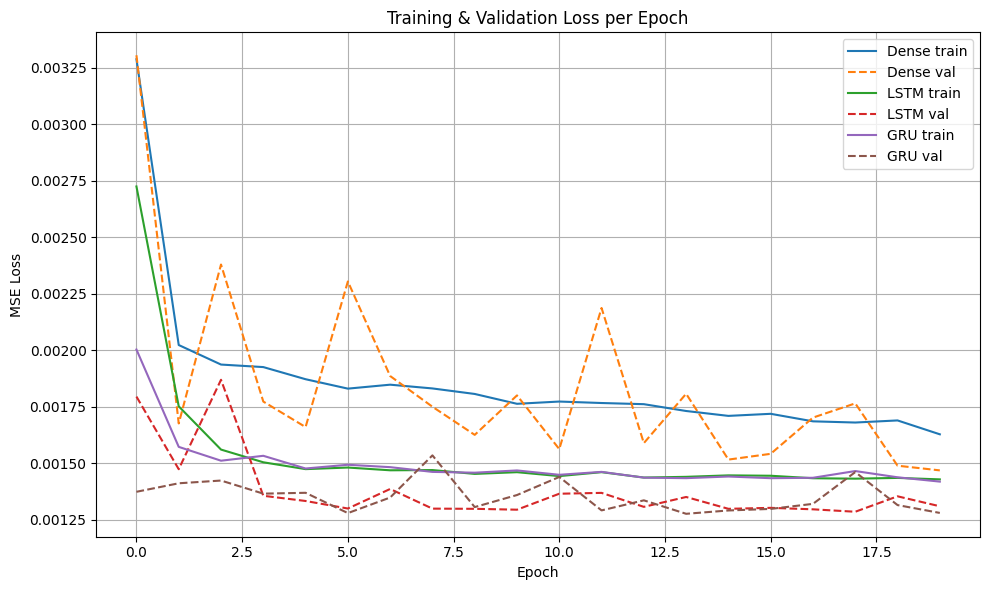

In [ ]:
plt.figure(figsize=(10,6))
for name, hist in histories.items():
    # loss
    plt.plot(hist.history['loss'],     label=f'{name} train')
    plt.plot(hist.history['val_loss'], label=f'{name} val', linestyle='--')

plt.title('Training & Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate
results = []
for name, model in models.items():
    y_pred = model.predict(X_test).ravel()
    mse    = mean_squared_error(y_true, y_pred)
    mae    = mean_absolute_error(y_true, y_pred)
    r2     = r2_score(y_true, y_pred)
    cosd   = np.mean([cosine([yt], [yp]) for yt, yp in zip(y_true, y_pred)])
    results.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'Cosine Distance': cosd
    })

df_results = pd.DataFrame(results).sort_values('R²', ascending=False)
print(df_results)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
   Model       MSE       MAE        R²  Cosine Distance
1   LSTM  0.001289  0.024377  0.806027     1.252561e-08
2    GRU  0.001297  0.024783  0.804753     6.910684e-09
0  Dense  0.001468  0.028169  0.778972     9.502190e-09


<h3 style="color:#79ff00">Bidirectional Models</h3>

In [21]:
def build_bi_lstm(input_window, n_features):
    model = Sequential([
        InputLayer(input_shape=(input_window, n_features)),
        Bidirectional(LSTM(64, activation='tanh', return_sequences=False)),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(5e-3), loss='mse', metrics=['mae'])
    return model

def build_bi_gru(input_window, n_features):
    model = Sequential([
        InputLayer(input_shape=(input_window, n_features)),
        Bidirectional(GRU(64, activation='tanh', return_sequences=False)),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(5e-3), loss='mse', metrics=['mae'])
    return model


In [22]:
n_features = X_train.shape[2]
input_window = X_train.shape[1]

bi_models = {
    'BiLSTM': build_bi_lstm(input_window, n_features),
    'BiGRU':  build_bi_gru(input_window, n_features),
}

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
histories_bi = {}
for name, model in bi_models.items():
    print(f"\n--- Training {name} ---")
    histories_bi[name] = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=20,
        batch_size=32,
        callbacks=[es],
        verbose=1
    )


--- Training BiLSTM ---
Epoch 1/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 0.0050 - mae: 0.0441 - val_loss: 0.0018 - val_mae: 0.0293
Epoch 2/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0018 - mae: 0.0296 - val_loss: 0.0014 - val_mae: 0.0248
Epoch 3/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0015 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0234
Epoch 4/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.0015 - mae: 0.0270 - val_loss: 0.0015 - val_mae: 0.0274
Epoch 5/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0015 - mae: 0.0263 - val_loss: 0.0013 - val_mae: 0.0239
Epoch 6/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0014 - val_mae: 0.0249
Epoch 7/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0014 - val_mae: 0.0260
Epoch 8/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0015 - mae: 0.0262 - val_loss: 0.0013 - val_mae: 0.0235
Epoch 9/20
703/

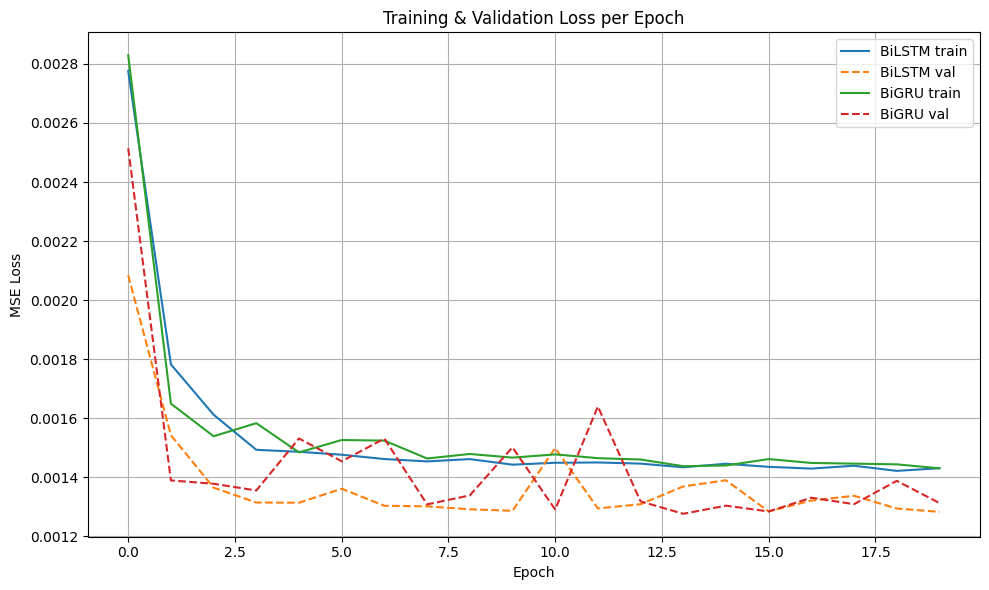

In [ ]:
plt.figure(figsize=(10,6))
for name, hist in histories_bi.items():
    # loss
    plt.plot(hist.history['loss'],     label=f'{name} train')
    plt.plot(hist.history['val_loss'], label=f'{name} val', linestyle='--')

plt.title('Training & Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
results_bi = []
hr_lag_1_idx = features_x.index('HR_lag_1')
y_true = Y_test.ravel()

for name, model in bi_models.items():
    y_pred = model.predict(X_test).ravel()
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    cosd = np.mean([cosine([yt], [yp]) for yt, yp in zip(y_true, y_pred)])
    results_bi.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'Cosine Distance': cosd
    })

df_results_bi = pd.DataFrame(results_bi).sort_values('R²', ascending=False)
print(df_results_bi)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
    Model       MSE       MAE        R²  Cosine Distance
1   BiGRU  0.001236  0.025325  0.813971     7.342601e-09
0  BiLSTM  0.001273  0.025886  0.808312     8.206436e-09


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step


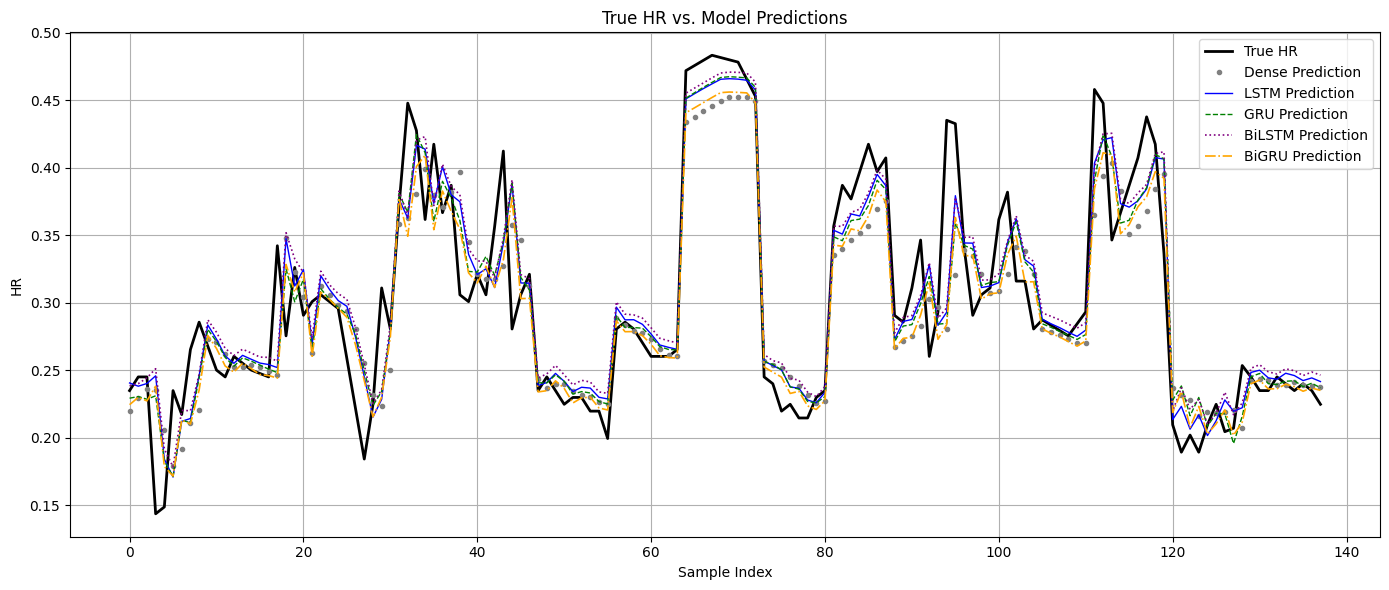

In [24]:
preds = {}
for name, m in models.items():
    preds[name] = m.predict(X_test).ravel()
for name, m in bi_models.items():
    preds[name] = m.predict(X_test).ravel()

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='True HR', color='black', linewidth=2)

styles = {
    'Dense':    ('o','gray',     0.5),
    'LSTM':     ('-','blue',     1.0),
    'GRU':      ('--','green',   1.0),
    'BiLSTM':   (':','purple',   1.2),
    'BiGRU':    ('-.','orange',  1.2),
}

for name, y_pred in preds.items():
    marker, color, lw = styles.get(name, ('','red',1.0))
    plt.plot(
        y_pred,
        label=f'{name} Prediction',
        color=color,
        linestyle=marker if marker in ['-','--',':','-.'] else '',
        marker=(marker if marker not in ['-','--',':','-.'] else ''),
        linewidth=lw,
        markersize=3
    )

plt.title('True HR vs. Model Predictions')
plt.xlabel('Sample Index')
plt.ylabel('HR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
window_size     = 12
n_features_in   = 6
forecast_window = 1

def gaussian_nll(y_true, y_pred):
    mu     = y_pred[..., :forecast_window]
    sigma2 = K.maximum(y_pred[..., forecast_window:], 1e-2)
    term1  = K.square(y_true - mu) / (2.0 * sigma2)
    term2  = 0.5 * K.log(sigma2)
    return K.mean(term1 + term2, axis=-1)

def build_lstm_gaussian():
    x_in   = Input(shape=(window_size, n_features_in), name='input_window')
    h      = LSTM(64, activation='tanh', name='shared_lstm')(x_in)
    mu     = Dense(forecast_window, activation='linear',   name='mu')(h)
    sigma2 = Dense(forecast_window, activation='softplus', bias_initializer=Constant(1.0), name='sigma2')(h)
    out    = Concatenate(name='out')([mu, sigma2])
    model  = Model(inputs=x_in, outputs=out, name='lstm_gaussian')
    model.compile(optimizer=Adam(1e-4), loss=gaussian_nll)
    return model

model = build_lstm_gaussian()
model.summary()


Model: "lstm_gaussian"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_window        │ (None, 12, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_lstm (LSTM)  │ (None, 64)        │     18,176 │ input_window[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 1)         │         65 │ shared_lstm[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigma2 (Dense)      │ (None, 1)         │         65 │ shared_lstm[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Concatenate)   │ (None, 2)         │          0 │ mu[0][0],         │
│                     │                   │            │ sigma2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,306 (71.51 KB)

 Trainable params: 18,306 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: -0.9240 - val_loss: -2.1891
Epoch 2/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: -2.1920 - val_loss: -2.2029
Epoch 3/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: -2.2015 - val_loss: -2.2062
Epoch 4/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: -2.2070 - val_loss: -2.2113
Epoch 5/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: -2.2067 - val_loss: -2.2130
Epoch 6/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: -2.2097 - val_loss: -2.2075
Epoch 7/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: -2.2092 - val_loss: -2.2142
Epoch 8/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: -2.2104 - val_loss: -2.2170
Epoch 9/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: -2.2107 - val_loss: -2.2106
Epoch 10/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: -2.2086 - val_loss: -2.2187
Epoch 11/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: -2.2102 - val_loss: -2.2189
Epoch 12/20
703

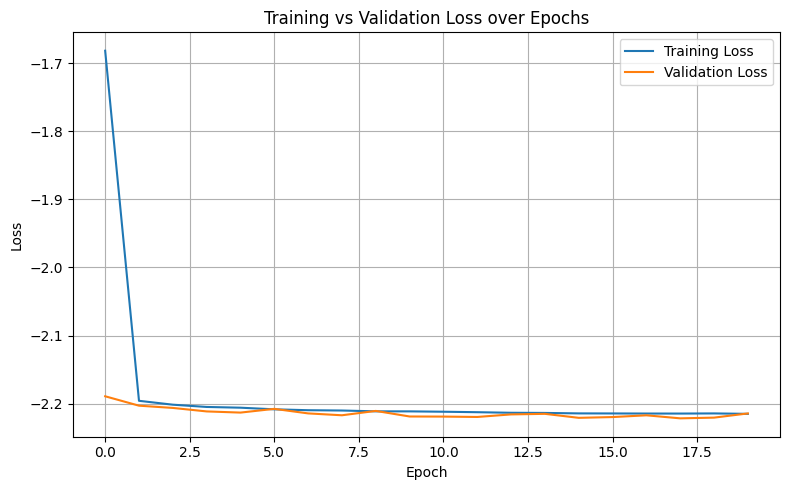

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
y_pred_all = model.predict(X_test)
mu_pred    = y_pred_all[:, 0]

y_true = Y_test.ravel()

mse = mean_squared_error(y_true, mu_pred)
mae = mean_absolute_error(y_true, mu_pred)
r2  = r2_score(y_true, mu_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² : {r2:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
MSE: 0.0016
MAE: 0.0292
R² : 0.7545


<h4 style="color:#79ff00"> Addding Noise</h4>

In [ ]:
patient_id = val_df['Patient_ID'].unique()[0]

df_patient = pd.concat([train_df, val_df])
df_patient = df_patient[df_patient['Patient_ID'] == patient_id].sort_values('Hour')

noisy = df_patient.copy()
noisy['HR_noisy'] = noisy['HR'] + np.random.laplace(loc=0.0, scale=1.0, size=len(noisy))

for lag in [1, 3, 6, 12]:
    noisy[f'HR_lag_{lag}'] = noisy['HR_noisy'].shift(lag)
noisy['HR_roll3'] = noisy['HR_noisy'].rolling(3).mean()

noisy.dropna(inplace=True)

features_x_noisy = ['Hour_scaled',
                    'HR_lag_1','HR_lag_3','HR_lag_6','HR_lag_12',
                    'HR_roll3']
target_col = 'HR_noisy'


In [ ]:
def make_windows_patient(df, feature_cols, input_window=12):
    X, hrs, hours = [], [], []
    arr = df[feature_cols].values
    hr_true = df[target_col].values
    H = len(df)
    for i in range(H - input_window):
        X.append(arr[i:i+input_window])
        hrs.append(hr_true[i+input_window])        # one-step ahead
        hours.append(df['Hour'].iloc[i+input_window])
    return np.array(X, dtype=np.float32), np.array(hrs, dtype=np.float32), np.array(hours)

X_pat, y_pat, hour_pat = make_windows_patient(noisy, features_x_noisy, input_window=12)

def build_bi_lstm_gaussian(window_size, n_feat):
    inp = Input(shape=(window_size, n_feat))
    h   = Bidirectional(LSTM(64, activation='tanh'))(inp)
    mu  = Dense(1, activation='linear')(h)
    sigma2 = Dense(1, activation='softplus')(h)
    out = Concatenate()([mu, sigma2])
    m = Model(inp, out)
    m.compile(optimizer=Adam(1e-4), loss=gaussian_nll)
    return m

model_bi = build_bi_lstm_gaussian(window_size=12, n_feat=len(features_x_noisy))

es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model_bi.fit(
    X_pat, y_pat,
    epochs=20,
    batch_size=16,
    callbacks=[es],
    verbose=1
)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - loss: 1.8333
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3014
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1322
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4829
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2359
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2740
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3435
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0955
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1047
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8564
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0082
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8667
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8916
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8444
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0614
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


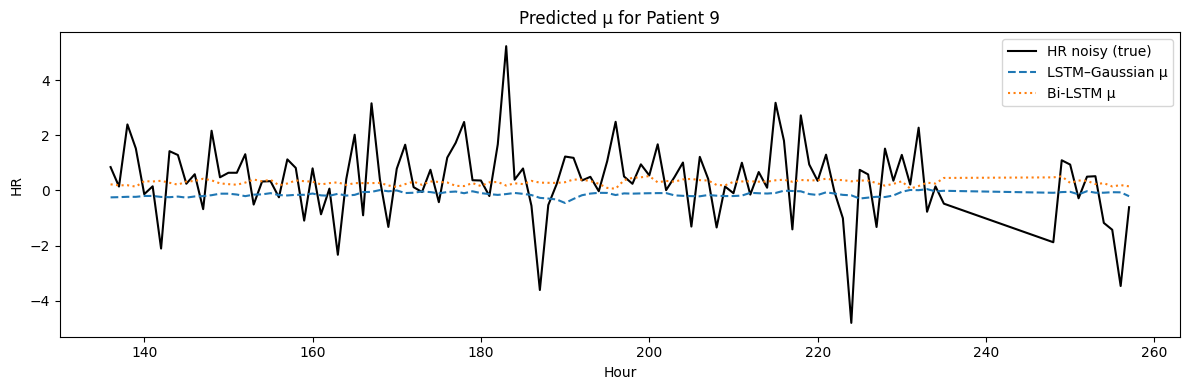

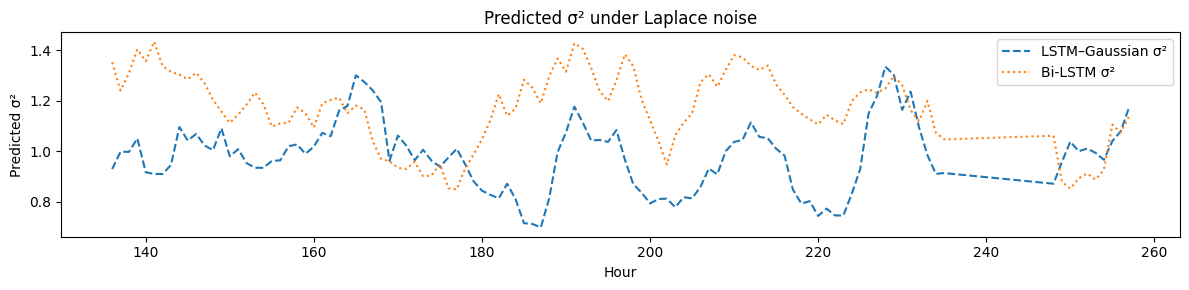

In [ ]:
X_pat_gauss = X_pat

pred_bi    = model_bi.predict(X_pat)        # shape = (N,2)
pred_gauss = model.predict(X_pat_gauss)

mu_bi    = pred_bi[:,0]
sigma2_bi= pred_bi[:,1]
mu_g     = pred_gauss[:,0]
sigma2_g = pred_gauss[:,1]

plt.figure(figsize=(12,4))
plt.plot(hour_pat, noisy['HR_noisy'].iloc[12:].values, label='HR noisy (true)', color='black')
plt.plot(hour_pat, mu_g,    label='LSTM–Gaussian μ', linestyle='--')
plt.plot(hour_pat, mu_bi,   label='Bi-LSTM μ',         linestyle=':')
plt.xlabel('Hour')
plt.ylabel('HR')
plt.title(f'Predicted μ for Patient {patient_id}')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(12,3))
plt.plot(hour_pat, sigma2_g, label='LSTM–Gaussian σ²', linestyle='--')
plt.plot(hour_pat, sigma2_bi,label='Bi-LSTM σ²',        linestyle=':')
plt.xlabel('Hour')
plt.ylabel('Predicted σ²')
plt.title(f'Predicted σ² under Laplace noise')
plt.legend()
plt.tight_layout()
